# Introducción

*Preliminares*

La ecuación de Schrödinger en el espacio de configuración es, probablemente, una de las ecuaciones que más información nos pueden dar sobre el mundo microscópico. Como toda ecuación diferencial, sólo se conocen soluciones exactas para los potenciales más sencillos. Cuando queremos considerar sistemas más elaborados hay dos sopas: usar métodos perturbativos y aproximaciones por series de potencias, o usar métodos numéricos. 

Este problema consiste en resolver la ecuación diferencial de segundo orden
$$
\left(-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x) \right)\psi(x) = E \psi(x)
$$

donde $V(x)$ es el potencial al que está sometida la partícula y $|\psi(x)|^2$ la probabilidad de encontrarla en la posición $x$.

*Método de numerov*

El método de Numerov es un método *marchante* que, a pesar de ser relativamente fácil de implementar, puede arrojar resultados muy cercanos a la realidad.

Para derivarlo, expandimos en serie de Taylor la versión discretizada de $\psi$:
$$\psi(x_{\pm 1})=\psi(x_0) \pm \psi'(x_0) \Delta + \frac{1}{2!}\psi''(x_0)
\Delta^2 \pm \frac{1}{3!}\psi^{(3)}(x_0) \Delta^3 + \frac{1}{4!}\psi^{(4)}(x_0)
\Delta^4 \pm \frac{1}{5!}\psi^{(5)}(x_0) \Delta^5 + \mathcal{O}(\Delta^6)$$

Si sumamos estos compas, tenemos que las potencias impares se nos van:
$$\psi(x_{+ 1})+\psi(x_{- 1}) =2\psi(x_0)  + \psi''(x_0)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_0)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Si definimos $\delta(g(x))=g(x+\Delta/2) - g(x-\Delta/2)$, tenemos que

$$\delta^2 = \delta(\delta(g))= g(x+\Delta)-g(x) - (g(x) - g(x-\Delta)) $$

Si le aplicamos esta chulada a $\psi$, tenemos que:

$$\delta^2(\psi_n) = \psi_{n+1}  + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\psi^{(4)}(x_n)
\Delta^4 + \mathcal{O}(\Delta^6)$$

Ahora vemos cómo se vería la cuarta derivada como función de la segunda
derivada:

$$\delta^2(\psi''_n) = \psi''_{n+1} + \psi''_{n-1} - 2\psi''_n  = \psi^{(4)}(x_0)
\Delta^2 + \mathcal{O}(\Delta^4)$$ y lo enchufamos en la expresión anterior:

$$\delta^2(\psi_n) = \psi_{n+1} + \psi_{n-1} - 2\psi_n  = \psi''(x_n)
\Delta^2 + \frac{1}{12}\delta^2(\psi''(x_n))
\Delta^2 + \mathcal{O}(\Delta^6)$$

De la ec. de Schrödinger tenemos que $\psi''(x)=f(x)\psi(x)$, con $f(x) = V(x)-E$, que
en lenguaje discreto se ve como $\psi''_n=f_n\psi_n$. Podemos usar esto en la
ecuación anterior para cambiar poner a todas las segundas derivadas en función
de $\psi$:
$$ \psi_{n+1}+\psi_{n-1} - 2\psi_n  = f_{n}\psi_{n}
\Delta^2 + \frac{1}{12}(f_{n+1}\psi_{n+1} + f_{n-1}\psi_{n-1} - 2f_{n}\psi_{n})
\Delta^2 + \mathcal{O}(\Delta^6)$$

Ahora bien, si pasamos los $f_i\psi_i$, del lado izquierdo, se tiene que

$$ \psi_{n+1}\left(1 - \frac{\Delta^2 f_{n+1}}{12}\right) + \psi_{n-1}\left(1 - \frac{\Delta^2 f_{n-1}}{12}\right) - 2\psi_n\left(1 - \frac{\Delta^2 f_{n} }{12}\right)  = f_{n}\psi_{n}
\Delta^2 + \mathcal{O}(\Delta^6)$$ que haciendo $\phi_n = \psi_n(1-\Delta ^2 f_n/12)$ toma la forma

$$ \phi_{n+1} + \phi_{n-1}- 2\phi_n  = f_{n}\psi_{n}
\Delta^2 $$ 

O bien,
$$ \phi_{n+1} =  2\phi_n - \phi_{n-1}  + f_{n}\psi_{n}
\Delta^2 $$ 

De esta fórmula vemos que el método de numerov (como todos los métodos numéricos para segundas derivadas) necesita dos puntos iniciales para empezar a trabajar.

# Un ejemplo sencillo: pozo infinito

Consideremos la ecuación de Ezkrotinger con un potencial de la forma 
$$
V(x)
\cases{
0, x \in [0,L]\\
\infty, x \notin [0,L]
}
$$

Aunque computacionalmente no es posible usar valores no acotados, el significado físico del potencial infinito es que ahí la función de onda vale 0, lo cual nos da condiciones de frontera en $x=0$ y $x=L$. De ahora en adelante tomaremos $\hbar = L=1$ y $m=1/2$ para simplificar las ecuaciones. En ese caso, sabemos que nuestras soluciones son de la forma 
$$
\psi_n = \sin(kx); \quad k = n\pi \Rightarrow E=n^2\pi^2
$$

In [1]:
using PyPlot

In [2]:
#Definimos 
function numerov (N, E, f)
    g(x) = (f(x) - E)
    Delta = 1/N
    phi = zeros(N)
    #definimos los primeros dos elementos
    phi[1] = 0
    phi[2] = 0.001(1 - Delta^2 * g(0)/12)
    #hacemos el paso iterativo
    for i in 3:N
        phi[i] = 2*phi[i - 1] - phi[i - 2] + Delta^2 * g((i - 1) * Delta) * phi[i - 1] / (1 - Delta^2 * g((i - 1) * Delta)/12)
    end
    #regresamos el valor de cada ψ_n  en un arreglo
    return [phi[i]/((1 - Delta^2 * g((i - 1) * Delta)/12)) for i in 1:N]
end
numerov(1000, 5, f)


Use "numerov(" instead.


LoadError: LoadError: UndefVarError: f not defined
while loading In[2], in expression starting on line 16

Para normalizar necesitamos calcular la integral (discreta) de nuestra función. Esta tendrá la forma $|\psi|^2=\sum\psi_i^2\Delta$:

In [3]:
function numerov_normaliza (N, E, f)
    norma=0
    phi = numerov (N, E, f)
    for i in 1:N
        norma += (phi[i])^2 * (1/N)#Se va acumulando el valor de la integral
    end
    return phi ./ norma #Se regresa el arreglo de ψ con cada entrada dividida entre la norma.
end


Use "numerov_normaliza(" instead.

Use "numerov(" instead.


numerov_normaliza (generic function with 1 method)

# Método de igualación

In [4]:
N = 100
x = zeros(N);

In [5]:
dx=1e-2

0.01

## Potencial

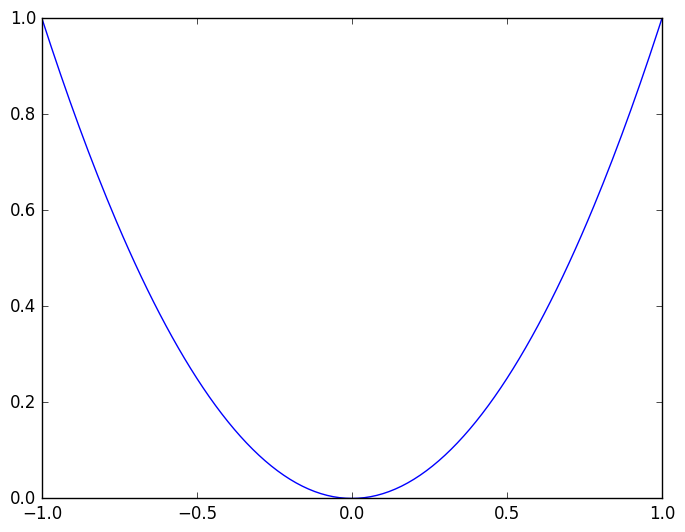

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdbfaf6d8>

In [134]:
V = Float64[]

for x in -1:dx:1
    push!(V,x^2)
end

x = [-1:dx:1]
plot(x,V)

## Funciones a lo pendejo

adivinanza

In [22]:
E = 1.4

1.4

In [8]:
Ψl = zeros(V)
Ψl[1] = 0
Ψl[2] = dx

0.01

In [23]:
for i in 2:length(V) - 1
    Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
end

In [24]:
Ψr = zeros(V)
Ψr[end] = 0
Ψr[end-1] = dx

0.01

In [25]:
for i in reverse(2:length(V) - 1)
    Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
end

In [31]:
(Ψl[floor(end/2)]-Ψl[floor(end/2)-1])/dx

0.0032430905588909376

In [32]:
(Ψr[floor(end/2)]-Ψr[floor(end/2)-1])/dx

0.05308350167689824

In [42]:
function bisec(a,b,paso,f)
    if paso == 100
        (a + b)/2
    elseif sign(f(a)) != sign(f((a+b)/2))
        bisec(a,(a + b)/2,paso + 1,f)
    elseif sign(f(b)) != sign(f((a + b)/2))
        bisec((a + b)/2,b,paso + 1,f)
    else
        println("La función no cambia de signo en $a, $b.")
        println("Intenta con otro intervalo.")
    end
end

bisec (generic function with 2 methods)

In [62]:
bisec(5.,15.,1,derivs)

11.412492628419486

In [47]:
using PyPlot

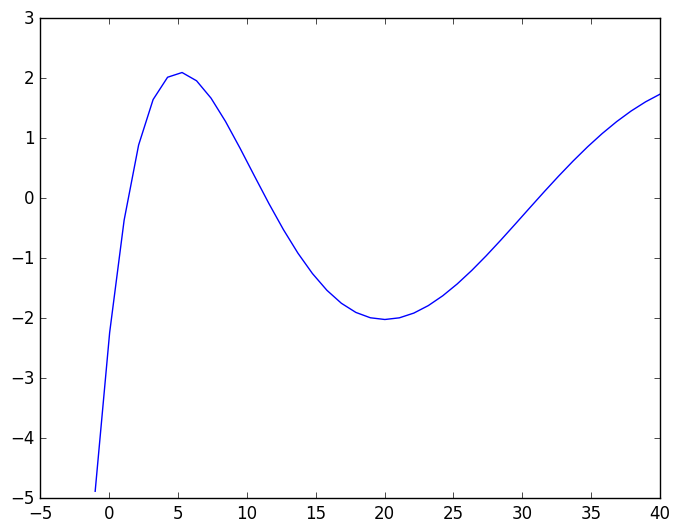

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccddafc9e8>

In [57]:
x = linspace(-1,40,40)
y = [derivs(u) for u in x]
plot(x,y)

In [45]:
function derivs(E)
    Ψl = zeros(V)
    Ψl[1] = 0
    Ψl[2] = dx
    Ψr = zeros(V)
    Ψr[end] = 0
    Ψr[end-1] = dx
    for i in 2:length(V) - 1
        Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
    end
    for i in reverse(2:length(V) - 1)
        Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
    end
    (Ψr[floor(end/2)]-Ψr[floor(end/2)-1])/dx-(Ψl[floor(end/2)]-Ψl[floor(end/2)-1])/dx
end

derivs (generic function with 1 method)

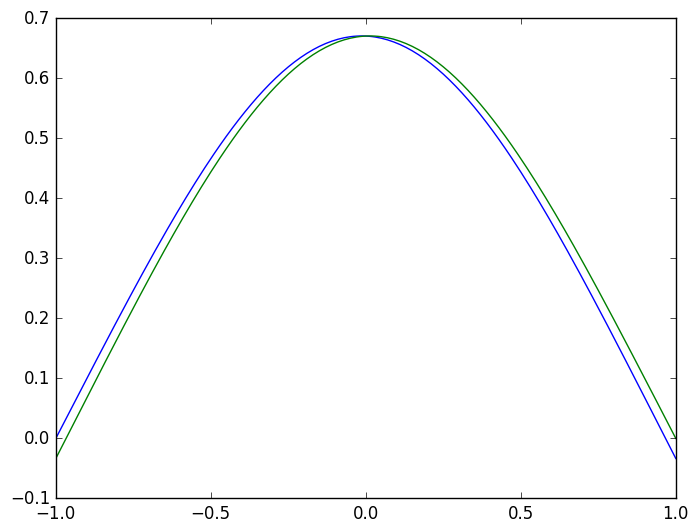

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccde03ec50>

In [26]:
plot(x,Ψl)
plot(x,Ψr)

Emparejamiento en un punto

Emparejamiento en un punto de las __derivadas__

In [114]:
function psis(E,a=1,b=1)
    Ψl = zeros(V)
    Ψl[1] = 0
    Ψl[2] = dx
    Ψr = zeros(V)
    Ψr[end] = 0
    Ψr[end-1] = dx
    for i in 2:length(V) - 1
        Ψl[i+1] = 2Ψl[i] - Ψl[i-1] - 2*(dx)^2*(E-V[i])*Ψl[i]
    end
    for i in reverse(2:length(V) - 1)
        Ψr[i-1] = 2Ψr[i] - Ψr[i+1] - 2*(dx)^2*(E-V[i])*Ψr[i]
    end
    plot(x,a.*Ψl)
    plot(x,b.*Ψr)
end

psis (generic function with 3 methods)

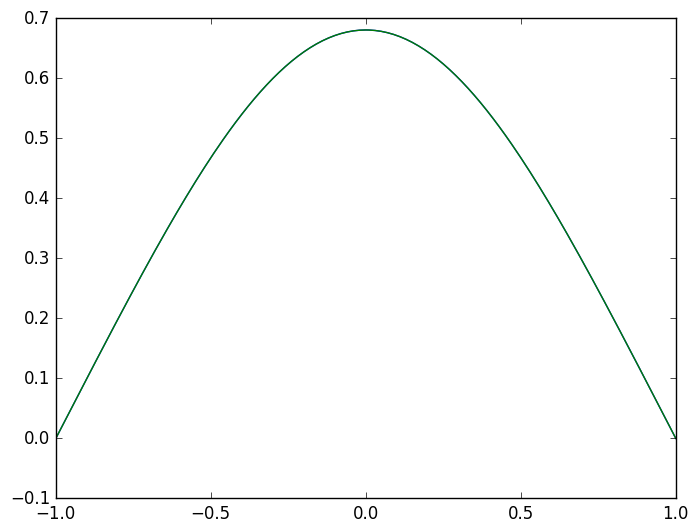

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdbf99b70>

In [135]:
psis(1.3620447487342902)

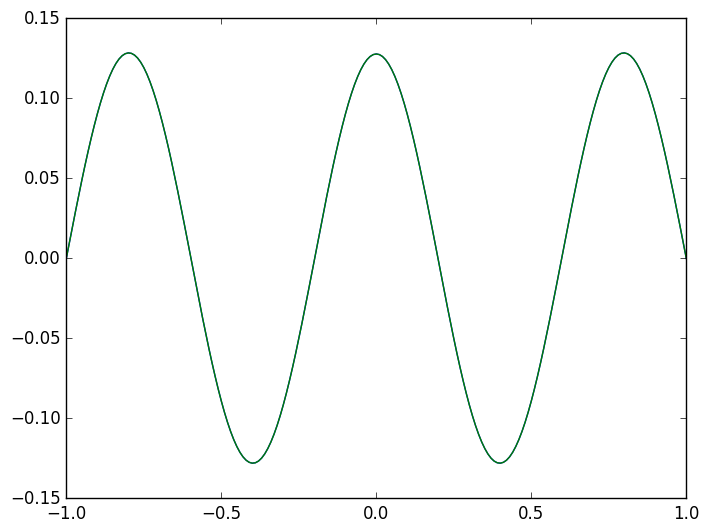

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdd9c5c88>

In [61]:
psis(31.15239599207232)

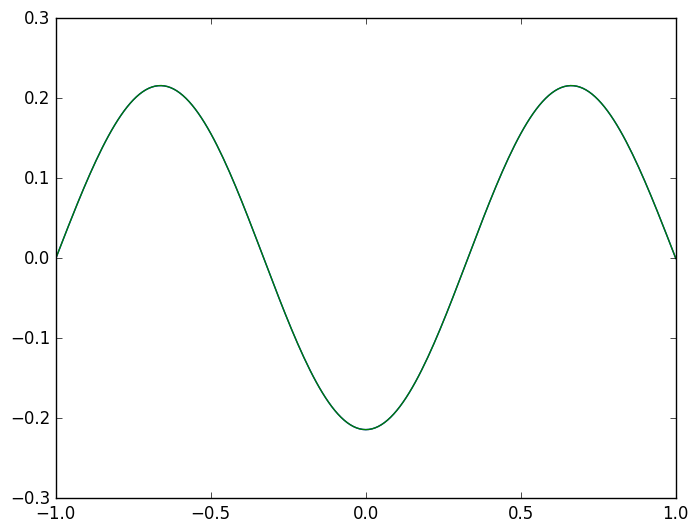

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdd99eb00>

In [63]:
psis(11.412492628419486)

# Otro potencial

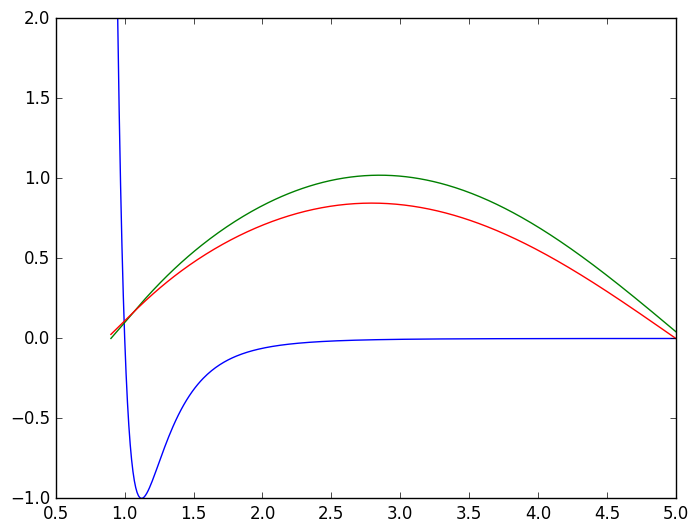

(-1,2)

In [182]:
V = Float64[]
for x in .9:dx:5
    push!(V,4(1/x^12-1/x^6))
end

x = [.9:dx:5]
plot(x,V)
psis(.25,1,.6)
ylim(-1,2)

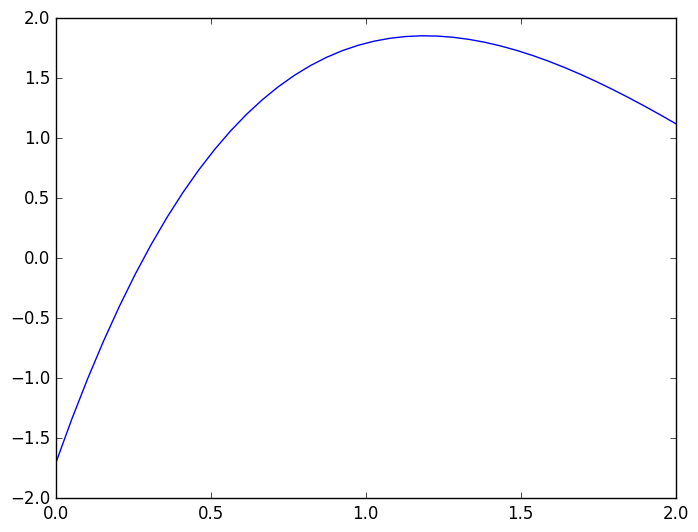

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdc4ca630>

In [82]:
x = linspace(0,2,40)
y = [derivs(u) for u in x]
plot(x,y)

In [162]:
bisec(0.,3,1,derivs)

0.26151226557995577

In [79]:
using Interact

  likely near /home/david/.julia/v0.4/Interact/src/IJulia/setup.jl:153
  likely near /home/david/.julia/v0.4/Interact/src/IJulia/setup.jl:157
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/david/.julia/v0.3/IJulia/src/execute_request.jl:177
 in eventloop at /home/david/.julia/v0.3/IJulia/src/IJulia.jl:144
 in anonymous at task.jl:447
while loading /home/david/.julia/v0.4/Interact/src/IJulia/statedict.jl, in expression starting on line 1


Interact.Slider{Float64}([Reactive.Input{Float64}] 2.5,"a",2.5,2.0:0.001:3.0)

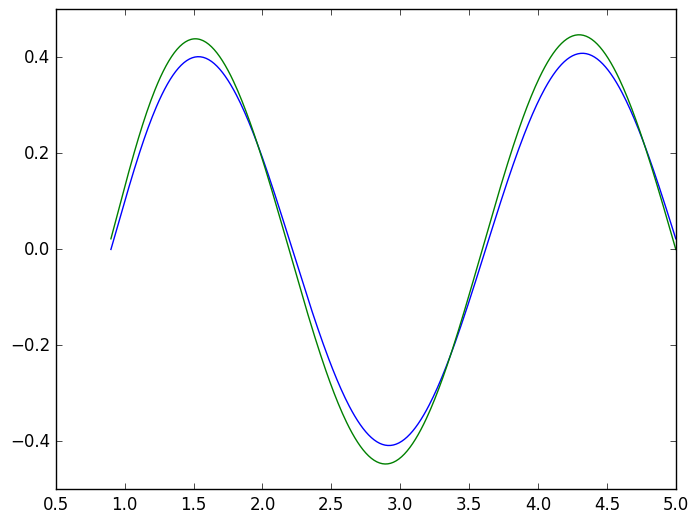

In [163]:
fig = figure()

@manipulate for a in 2:0.001:3
    withfig(fig) do
        psis(a)
    end
end

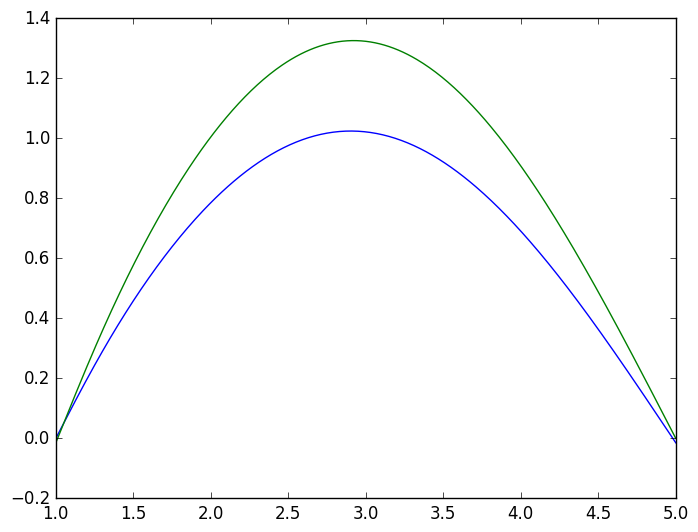

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fccdc372f98>

In [86]:
psis(0.2829412375635918)